In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint, Bounds
import scipy.special
from tqdm import tqdm

In [9]:
beta = 1
B = 0
kappa = 2
# The states are marked mu(x0, k), where x0 is the spin of the root node and k is the number of
# leaves that are spin-up
multiplicity = np.fromfunction(lambda _, k: scipy.special.comb(kappa, k), (2, kappa+1))
eta = multiplicity / (2 ** (kappa+1))
print(f'{eta=}')

def Hamiltonian(x0, k):
    x0 = 2 * x0 - 1
    return beta / 2 * x0 * (2 * k - kappa) + B * x0

def relative_entropy(p, q):
    return np.sum(p * np.log(p / q))

def edge_distribution(p):
    counts = np.vstack((kappa - np.arange(kappa+1),
                        np.arange(kappa+1)))
    return p @ counts.T / kappa

def target_function(mu):
    hamiltonian = np.fromfunction(Hamiltonian, (2, kappa+1))
    exp = np.sum(hamiltonian * mu)
    rel_entr = relative_entropy(mu, eta)
    pi_mu = edge_distribution(mu)
    pi_eta = edge_distribution(eta)
    marg_rel_entr = relative_entropy(pi_mu, pi_eta)
    return exp - rel_entr + marg_rel_entr
    
def norm_constraint(mu):
    return np.sum(mu) - 1

# def norm_constraint_grad(mu):
#     return mu

def admissibility_constraint(mu):
    pi_mu = edge_distribution(mu)
    return pi_mu[0, 1] - pi_mu[1, 0]

# def admissibility_constraint_grad(mu):
#     grad_01 = np.concatenate([kappa - np.arange(kappa+1),
#                               np.zeros((1, kappa+1))], axis=0)
#     grad_10 = np.concatenate([np.zeros((1, kappa+1)),
#                               np.arange(kappa+1)], axis=0)
#     return grad_01 - grad_10

print(f'{edge_distribution(eta)=}')

eta=array([[0.125, 0.25 , 0.125],
       [0.125, 0.25 , 0.125]])
edge_distribution(eta)=array([[0.25, 0.25],
       [0.25, 0.25]])


In [113]:
def optimize(x0, lam0, patience, eps, verbose=True):

    x = x0
    lam = lam0
    
    target = -np.inf
    for it in range(patience):
        if verbose:
            print(f"{it=}")

        # Redefine the function for scipy.optimize.minimize
        # There is probably some fancy functional-programming way to incorporate lambda
        # but you get the point.
        def proximal_target_function(_x):
            _x = _x.reshape((2, kappa+1))
            _mu = np.exp(_x)
            _norm_constraint = norm_constraint(_mu)
            _admissibility_constraint = admissibility_constraint(_mu)
            return -target_function(_mu) \
                - lam[0] * _norm_constraint \
                - lam[1] * _admissibility_constraint \
                + _norm_constraint ** 2 / 2 \
                + 1000 * _admissibility_constraint ** 2 / 2
        
        # Calculate proximal point
        res = minimize(proximal_target_function, x0=x.flatten(), method='l-bfgs-b')
        if not res.success:
            print(f'Proximal Point minimization not successful: {res.message}')
            return x, target
        new_x = res.x.reshape((2, kappa+1))
        
        new_mu = np.exp(new_x.reshape(2, kappa+1))
        new_target = target_function(new_mu)
        _norm_constraint = norm_constraint(new_mu)
        _admissibility_constraint = admissibility_constraint(new_mu)
        if verbose:
            print(f"{new_target=:.4e}\t{_norm_constraint=:.4e}\t{_admissibility_constraint=:.4e}")
            
        # Decide whether to terminate
        if np.abs(target - new_target) < eps and np.all(np.abs(mu - new_mu) < eps) and np.abs(_norm_constraint) < eps and np.abs(_admissibility_constraint) < eps:
            return x, target
        target = new_target
        x = new_x
        mu = new_mu
        
        # Update lambda
        lam[0] = lam[0] - _norm_constraint
        lam[1] = lam[1] - 1000 * _admissibility_constraint
    print(f'Reached Patience: {new_target=:.4e}\t{_norm_constraint=:.4e}\t{_admissibility_constraint=:.4e}')
    return x, target

In [137]:
def optimize(mu0):
    # bounds = np.hstack([
    #     np.zeros_like(mu0.flatten())[:, np.newaxis],
    #     np.ones_like(mu0.flatten())[:, np.newaxis]
    # ])
    chi0 = np.log(mu0)
    # bound = Bounds(np.zeros_like(chi0.flatten()), np.inf)

    # norm_constraint = LinearConstraint(np.ones_like(chi0.flatten()), 1, 1)
    norm_constraint = NonlinearConstraint(lambda chi: np.sum(np.exp(chi)), lb=1, ub=1)
                                        #   jac=lambda chi0: np.exp(chi0),
                                        #   hess=lambda chi0: np.diag(chi0))
    admissibility_linear = np.hstack((np.arange(kappa+1), kappa - np.arange(kappa+1))) / kappa
    admissibility_constraint = NonlinearConstraint(lambda chi: admissibility_linear @ np.exp(chi), lb=0, ub=0)
                                                # jac=lambda chi0: admissibility_linear * np.exp(chi0),
                                                # hess=lambda chi0: np.diag(admissibility_linear * np.exp(chi0)))
    
    res = minimize(lambda chi: -target_function(np.exp(chi).reshape(2, kappa+1)),
                   x0=chi0.flatten(), method='trust-constr', 
                   constraints=[norm_constraint, admissibility_constraint],
                   options={'verbose': 0})
    
    return res

beta = 1
B = 0
mu0 = np.random.uniform(0, 1, (2, kappa+1))
print(f'{mu0=}\n')
res = optimize(mu0)
mu = np.exp(res.x).reshape(2, kappa+1)
print(f'{target_function(mu)=}\n')
print(f'{mu=}\n\n{np.sum(mu)=}\n\n{edge_distribution(mu)=}')

mu0=array([[0.59225882, 0.21102029, 0.45189306],
       [0.18503061, 0.7891408 , 0.60350823]])

target_function(mu)=0.30686551395361206

mu=array([[3.95354736e-01, 2.01072544e-06, 4.75230030e-10],
       [1.19916322e-07, 1.14632483e-07, 6.04643031e-01]])

np.sum(mu)=1.0000000134993585

edge_distribution(mu)=array([[3.95355742e-01, 1.00583795e-06],
       [1.77232564e-07, 6.04643089e-01]])


In [170]:
point_cloud = []
for it in tqdm(range(100)):
    mu0 = np.random.uniform(0.5, 0.6, (2, kappa+1))
    res = optimize(mu0)
    mu = np.exp(res.x).reshape(2, kappa+1)
    
    point_cloud.append(mu.flatten())
    
point_cloud = np.array(point_cloud)

 16%|█▌        | 16/100 [00:16<01:32,  1.11s/it]/Users/yizhonghu/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/yizhonghu/anaconda3/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
100%|██████████| 100/100 [02:15<00:00,  1.36s/it]


In [ ]:
from sklearn.decomposition import PCA

precisions = []

for dims in range(6):
    pca = PCA(n_components=dims+1)
    pca.fit(point_cloud)
    precisions.append(pca.score(point_cloud))
    
print(precisions)

[61.58948159418249, 64.91703938522286, 67.62080087069029, 68.96626832926269, 70.21510644361824, 70.24151585740212]


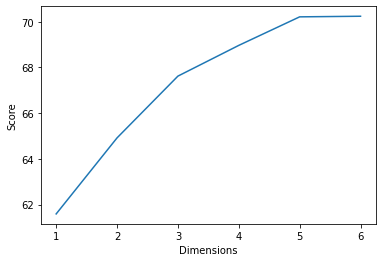

In [ ]:
plt.plot(np.arange(6)+1, precisions)
plt.xlabel('Dimensions')
plt.ylabel('Score')
plt.savefig('../img/pca_partial.png')

In [230]:
beta = 1
B = 0

x0 = np.random.uniform(-10, 10, (2, 3))
# x0 = np.zeros((2, kappa+1))

x, target = optimize(x0, lam0=np.zeros(2), patience=2000, eps=1e-6, verbose=False)
mu = np.exp(x)
print(f'{np.sum(mu)=}, {target=}')
mu

np.sum(mu)=0.9999997864538266, target=0.43378066628936596


array([[0.3877483 , 0.10495102, 0.00712468],
       [0.00708234, 0.10503461, 0.38805884]])

### P(X0, X1)

In [77]:
pi_mu = edge_distribution(mu)
print(f'{pi_mu=}')
p_x0 = np.sum(pi_mu, axis=1)
p_x1 = np.sum(pi_mu, axis=0)
print(f'{p_x0=}', f'{p_x1=}')
print(f'{np.outer(p_x0, p_x1)=}')

pi_mu=array([[3.27776120e-01, 9.27474153e-10],
       [9.27474153e-10, 6.72223883e-01]])
p_x0=array([0.32777612, 0.67222388]) p_x1=array([0.32777612, 0.67222388])
np.outer(p_x0, p_x1)=array([[0.10743719, 0.22033894],
       [0.22033894, 0.45188495]])


### P(X1, X2)

In [52]:
mu_edge = np.sum(mu, axis=0)
leaf_dist = np.array([[mu_edge[2], mu_edge[1] / 2],
                      [mu_edge[1] / 2, mu_edge[0]],])
print(f'{leaf_dist=}')
p_x1 = np.sum(pi_mu, axis=1)
p_x2 = np.sum(pi_mu, axis=0)
print(f'{p_x1=}', f'{p_x2=}')
print(f'{np.outer(p_x1, p_x2)=}')

leaf_dist=array([[5.29443441e-01, 1.36443170e-09],
       [1.36443170e-09, 4.70556560e-01]])
p_x1=array([0.47055656, 0.52944344]) p_x2=array([0.47055656, 0.52944344])
np.outer(p_x1, p_x2)=array([[0.22142348, 0.24913309],
       [0.24913309, 0.28031036]])


### P(X1, X2 | X0)

In [54]:
x0 = 0
mu_edge = mu[x0] / np.sum(mu, axis=1)[x0]
print(f'{mu_edge=}')
leaf_dist = np.array([[mu_edge[2], mu_edge[1] / 2],
                      [mu_edge[1] / 2, mu_edge[0]],])
print(f'{leaf_dist=}')
p_x1 = np.sum(pi_mu, axis=1)
p_x2 = np.sum(pi_mu, axis=0)
print(f'{p_x1=}', f'{p_x2=}')
print(f'{np.outer(p_x1, p_x2)=}')

mu_edge=array([9.99999996e-01, 2.89961252e-09, 1.44980627e-09])
leaf_dist=array([[1.44980627e-09, 1.44980626e-09],
       [1.44980626e-09, 9.99999996e-01]])
p_x1=array([0.47055656, 0.52944344]) p_x2=array([0.47055656, 0.52944344])
np.outer(p_x1, p_x2)=array([[0.22142348, 0.24913309],
       [0.24913309, 0.28031036]])
